## 07 - Image descriptors

Moacir A. Ponti - ICMC/USP

### Part 3 - Bag of Features

**Bag of Features** (or Bag of Visual Words) is a framework to learn descriptors based on patches of data.

It has the following general steps:

1. extract features locally

2. quantize or cluster the local features
    
3. learn a vocabulary of visual words: dictionary
    
4. obtain descriptors as the frequency of visual words in an image, i.e. histogram

This technique was inspired on Textons for texture analysis and the Bag-of-Words method for text analysis.

---

<img src=images/textons1.jpg width=720>

In the example above, we have 3 images, represented using a set of representatives subimages forming a **visual dictionary**

In order to describe each subimage:
* the actual pixel space
* extracted features/descriptors.

From each subimage, we check its similarity with the dictionary and count the ocurrence of the most similar visual word.

<img src=images/textons2.jpg width=720>

--- 
The steps

1. define the base features

2. extract the features locally from *patches*, e.g. subimages

<img src=images/bof1.jpg width=680>

3. feature space is formed by multiple local feature vectors
    * multiple vectors per image, extracted from *patches*

<img src=images/bof2.jpg width=680>

   
4. learn a *dictionary* with $K$ visual words, 
    * quantize the features
    * run a clustering algorithm

<img src=images/bof3.jpg width=680>        


5. the resulting descriptor is a histogram obtained by:
    1. set a *bin* for each dictionary word,
    2. extract the next *patch*
    3. count +1 to the codeword in the dictionary that is more similar to the features from the new *patch*

<img src=images/bof4.jpg width=680>    

---
### Step 1 - get images and patches

using function `extract_patches_2d()` from `sklearn.feature_extraction.image`

We are going to use also:
* joblib: Parallel, delayed - to execute function in parallel
* os: listdir - to list files in a folder

In [61]:
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from skimage import feature

def get_patches(img_file, random_state, patch_size=(11, 11), n_patches=250):
    '''Extracts subimages
       Parameters
           img_file: path for an image
           patch_size: size of each patch
           n_patches: number of patches to be extracted
    '''

    img = imread(img_file)
    
    # Extract subimages
    patch = extract_patches_2d(img, 
                               patch_size=patch_size,
                               max_patches=n_patches, 
                               random_state=random_state)
    
    return patch.reshape((n_patches, 
                          np.prod(patch_size) * len(img.shape)))

---

We have to define
* the size of the patch and number of patches per image
* the path to search for training images
* note each patch has an extra dimension due to the color channels (1 for graylevel, 3 for RGB) 

Patches extracted to create dictionary of features
Total of images =  80
Size of each array of patches =  (250, 675)


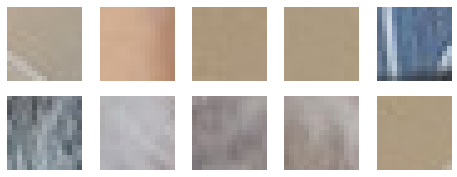

In [47]:
# BOF parameters
tam_patch = (15, 15)
n_patches = 250
path_imgs = './images/flickr_map_training/'
random_state = 1

# get list of files
l_imgs = listdir(path_imgs)
# total of images
n_imgs = len(l_imgs)

# Extract patches in parallel
# returns a list of the same size of the number of images
patch_arr = Parallel(n_jobs=-1)(delayed(get_patches)(path_imgs+arq_img, 
                                                    random_state,
                                                    tam_patch,
                                                    n_patches)
                                for arq_img in l_imgs)

print('Patches extracted to create dictionary of features')
print('Total of images = ', len(patch_arr))
print('Size of each array of patches = ', patch_arr[0].shape)

# shows some image patches
img_ind = 32
plt.figure(figsize=(8,3))
for i in np.arange(1,11):
    plt.subplot(2,5,i)
    plt.imshow(patch_arr[img_ind][i].reshape((tam_patch[0],tam_patch[1],3)))
    plt.axis('off')

---
### Step 2 - obtain features from patches

We are going to use LBP features as base descriptor

In [48]:
def lbp_features(img, radius=1, sampling_pixels=8):
    
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
    
    # normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    
    # compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns
    return hist

In [49]:
patch_arr = np.array(patch_arr, copy=True)
patch_arr = patch_arr.reshape((patch_arr.shape[0] * patch_arr.shape[1],
                               tam_patch[0],tam_patch[0],3))

# obtaining features lbp for each patch
patch_lbp = []
for pat in patch_arr:
        f = lbp_features(pat,2,8)
        patch_lbp.append(f)

patch_lbp = np.array(patch_lbp, copy=False)
print('Instances = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])
print('Created LBP feature spaces')
print('\tpatches = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])

Instances =  20000  size =  10
Created LBP feature spaces
	patches =  20000  size =  10


---
### Step 3 - learn dictionary

We are going to use a clustering algorithm, KMeans, defining the number of visual words
* can range from 25 to 1000    

In [54]:
n_dic = 50 # size of the dictionary
random_state = 1

# Define a KMeans clustering model
kmeans_model = KMeans(n_clusters=n_dic, 
                      verbose=False, 
                      init='random',
                      random_state=random_state, 
                      n_init=3)
# fit the model
kmeans_model.fit(patch_lbp)

KMeans(init='random', n_clusters=50, n_init=3, random_state=1, verbose=False)

(-0.01555555548641975,
 0.32666666521481474,
 -0.014444444380246913,
 0.30333333198518514)

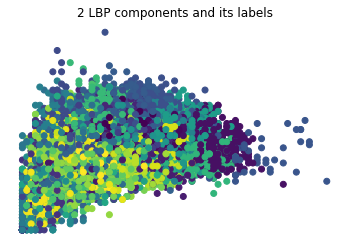

In [55]:
plt.scatter(patch_lbp[:, 0], patch_lbp[:, 1], c=kmeans_model.labels_)
plt.title('2 LBP components and its labels')
plt.axis('off')

---
### Step 4 - obtain histograms from Bag of features

Since we have `n_imgs` with `n_patches`

We check the frequency of each visual word in each training images

In [56]:
# compute features for each image
img_feats = []
for i in range(n_imgs):
    # predicting n_patches of an image
    y = kmeans_model.predict(patch_lbp[i*n_patches: (i*n_patches)+n_patches])

    # computes histogram and append in the array
    hist_bof,_ = np.histogram(y, bins=range(n_dic+1), density=True)
    img_feats.append(hist_bof)

img_feats = np.array(img_feats, copy=False)
print('Number of images and features = ', img_feats.shape)

Number of images and features =  (80, 50)


Array `img_feats` is a set of features for each image

---
### Step 5 - using features for recognition

Let us use the features for *content-based image retrieval*

Extracted patches
(250, 15, 15, 3)
LBP extractd
(250, 10)


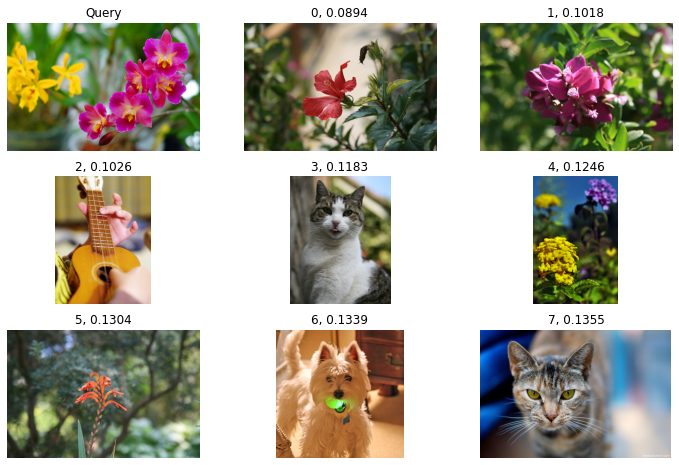

In [60]:
path_query = './images/flickr_map_test/flower.jpg'
# get query patches
query_patches = get_patches(path_query, random_state, tam_patch, n_patches)
query_patches = np.array(query_patches, copy=False)

query_patches = query_patches.reshape((query_patches.shape[0],
                               tam_patch[0],tam_patch[0],3))

print('Extracted patches')
print(query_patches.shape)

# get LBP feathres
query_lbp = []
for pat in query_patches:
        f = lbp_features(pat,2,8)
        query_lbp.append(f)

query_lbp = np.array(query_lbp, copy=False)
print('LBP extractd')
print(query_lbp.shape)

# get visual words for query
y = kmeans_model.predict(query_lbp)
# computes descriptor
query_feats,_ = np.histogram(y, bins=range(n_dic+1), density=True)

# computes distances
dists = []
for i in range(n_imgs):
    diq = np.sqrt(np.sum((img_feats[i]-query_feats)**2))
    dists.append(diq)

# check the nearest images
k = 8
k_cbir = np.argsort(dists)[:k]

import imageio
imgq = imageio.imread(path_query)

plt.figure(figsize=(12,8))
plt.subplot(331); plt.imshow(imgq)
plt.title('Query'); plt.axis('off')

imgs = []
for i in range(k):
    imgs.append(imageio.imread(path_imgs+l_imgs[k_cbir[i]]))
    plt.subplot(3,3,i+2); plt.imshow(imgs[i])
    plt.title('%d, %.4f' % (i, dists[k_cbir[i]])); plt.axis('off')